In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [30]:
def energy_functional(x, y, dy_dx):
    # Defines the energy functionalor aka the ODE/PDE based on the problem requirements. 
    # Here you can modify the functino yourself to match the energy function of your specific problem.
    # Like as an examle, if it's elasticity, you can use function of strain energy
    # Here, I defined a dummy function for simple demonstration.
    return 0.5 * (dy_dx ** 2) - x * y  # Example: strain energy with linear potential that I found online.

In [31]:
x_range = (0.1, 10)  # Range for x
initial_conditions = [
    {'type': 'y', 'value': 2.0, 'x': 1.0},    # y(0) = 0
    {'type': 'y\'', 'value': 0.0, 'x': 1.0},  # y'(0) = 1
    #{'type': 'y', 'value': 0.0, 'x': 2 * np.pi},  # y(2*pi) = 0
    # Additional initial conditions can be added if needed
    # {'type': 'y', 'value': ..., 'x': ...},
    # {'type': 'y\'', 'value': ..., 'x': ...}
]

In [32]:
learning_rate = 0.001 
num_epochs = 1000 

In [33]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.hidden_layer_1 = nn.Linear(1, 200)
        self.hidden_layer_2 = nn.Linear(200, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)
        self.output_layer = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.sigmoid(self.hidden_layer_1(x))
        x = torch.sigmoid(self.hidden_layer_2(x))
        x = torch.sigmoid(self.hidden_layer_3(x))
        x = self.output_layer(x)
        return x

In [34]:
def compute_energy_residual(x, net):
    # Calculating the energy residual from the energy functional
    y = net(x)  # Network approximation of y(x)
    dy_dx = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    
    # Energy functional
    energy = energy_functional(x, y, dy_dx)
    return energy

In [35]:
def apply_initial_conditions(net, initial_conditions):
    ivp_residuals = []
    for ivp in initial_conditions:
        x_ivp = torch.tensor([[ivp['x']]], requires_grad=True)  # Boundary point
        y_ivp = net(x_ivp)  # Predict y(x_ivp)

        if ivp['type'] == 'y':
            ivp_residual = y_ivp - ivp['value']  # y(x) = given value
        elif ivp['type'] == 'y\'':
            dy_dx_ivp = torch.autograd.grad(y_ivp, x_ivp, torch.ones_like(x_ivp), create_graph=True)[0]
            ivp_residual = dy_dx_ivp - ivp['value']
        
        ivp_residuals.append(ivp_residual ** 2)
    
    return torch.sum(torch.stack([ivp**2 for ivp in ivp_residuals]))

In [36]:
def train(net, optimizer, x_range, initial_conditions, num_epochs):
    x_min, x_max = x_range
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Sample points in the domain x
        x = torch.linspace(x_min, x_max, 100).view(-1, 1)
        x.requires_grad = True

        # Calculate the energy residual
        energy_residual = compute_energy_residual(x, net)

        # Initial condition residual
        ivp_residual = apply_initial_conditions(net, initial_conditions)

        # Total loss: Minimize energy functional plus initial conditions
        loss = torch.mean(energy_residual) + ivp_residual
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

In [37]:
net = Network()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [38]:
train(net, optimizer, x_range, initial_conditions, num_epochs)

Epoch 0, Loss: 30.959320068359375
Epoch 10, Loss: -10.61984920501709
Epoch 20, Loss: -13.630741119384766
Epoch 30, Loss: -14.822144508361816
Epoch 40, Loss: -15.064327239990234
Epoch 50, Loss: -15.892134666442871
Epoch 60, Loss: -16.70509147644043
Epoch 70, Loss: -17.840951919555664
Epoch 80, Loss: -19.402250289916992
Epoch 90, Loss: -21.333568572998047
Epoch 100, Loss: -23.613794326782227
Epoch 110, Loss: -26.25153160095215
Epoch 120, Loss: -29.209272384643555
Epoch 130, Loss: -32.387691497802734
Epoch 140, Loss: -35.67857360839844
Epoch 150, Loss: -39.06236267089844
Epoch 160, Loss: -42.69306564331055
Epoch 170, Loss: -46.72561264038086
Epoch 180, Loss: -51.03428268432617
Epoch 190, Loss: -55.52202606201172
Epoch 200, Loss: -60.071128845214844
Epoch 210, Loss: -64.59954071044922
Epoch 220, Loss: -69.06826782226562
Epoch 230, Loss: -73.48702239990234
Epoch 240, Loss: -77.8929214477539
Epoch 250, Loss: -82.32173156738281
Epoch 260, Loss: -86.8308334350586
Epoch 270, Loss: -91.394317626

In [39]:
def visualize_solution(net, x_range):
    x_min, x_max = x_range
    x_values = np.linspace(x_min, x_max, 100)
    x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)
    y_pred = net(x_tensor).detach().numpy()

    plt.plot(x_values, y_pred, label="DEM Solution")
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("Solution of the ODE learned by the Neural Network (DEM)")
    plt.legend()
    plt.grid(True)
    plt.show()

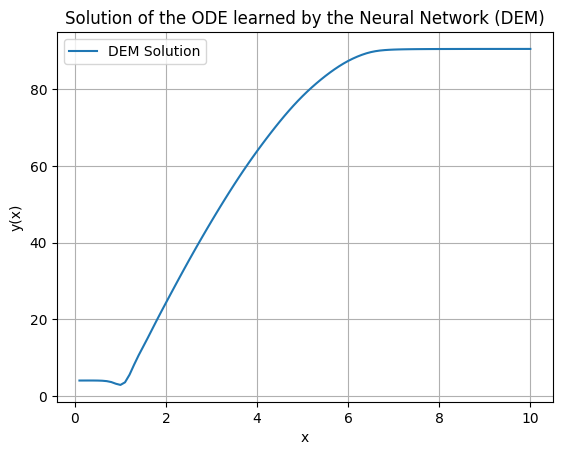

In [40]:
visualize_solution(net, x_range)